In [10]:
#Usar Python 2
from __future__ import division
import random
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz as w
from scipy.optimize import curve_fit


#Se define la función de costo para utilizar en el proceso de optimización

def f_clx(x,f1,f2,f3,f4,f5,f6,
          G1,G2,G3,G4,G5,G6,
          wo1,wo2,wo3,wo4,wo5,wo6):   #wo: eV

    epsilon = 1

    epsilon += f1/((x**2-wo1**2)- (1j*G1*x)) #χ1
                   
    epsilon += f2/((x**2-wo2**2)- (1j*G2*x)) #χ1
                   
    epsilon += f3/((x**2-wo3**2)- (1j*G3*x)) #χ1
                   
    epsilon += f4/((x**2-wo4**2)- (1j*G4*x)) #χ1
                   
    epsilon += f5/((x**2-wo5**2)- (1j*G5*x)) #χ1
                   
    epsilon += f6/((x**2-wo6**2)- (1j*G6*x)) #χ1
    
        
    n=(np.sqrt(epsilon)).real
    k=(np.sqrt(epsilon)).imag
   
    return np.hstack([n, k])

def func2(x,f1,f2,f3,f4,f5,f6,
          G1,G2,G3,G4,G5,G6,
          wo1,wo2,wo3,wo4,wo5,wo6):  

    epsilon = 1

    epsilon += f1/((wo1**2-x**2)- (1j*G1*x)) #χ1
                   
    epsilon += f2/((wo2**2-x**2)- (1j*G2*x)) #χ1
                   
    epsilon += f3/((wo3**2-x**2)- (1j*G3*x)) #χ1
                   
    epsilon += f4/((wo4**2-x**2)- (1j*G4*x)) #χ1
                   
    epsilon += f5/((wo5**2-x**2)- (1j*G5*x)) #χ1
                   
    epsilon += f6/((wo6**2-x**2)- (1j*G6*x)) #χ1
   
    return epsilon

def opt_JC(xx):
    
    a1=xx[0]
    a2=xx[1]
    a3=xx[2]
    a4=xx[3]
    a5=xx[4]
    a6=xx[5]
    b1=xx[6]
    b2=xx[7]
    b3=xx[8]
    b4=xx[9]
    b5=xx[10]
    b6=xx[11]
    c1=xx[12]
    c2=xx[13]
    c3=xx[14]
    c4=xx[15]
    c5=xx[16]
    c6=xx[17]
    
    #Se importan los datos que se busca optimizar, en este caso los datos son del índice de refracción
    
    file2 = np.loadtxt('sangre.txt')
    eV=file2[:,0]
    n_JC=file2[:,1] + 1j*file2[:,2]
    n=file2[:,1]
    k=file2[:,2]
  

    #Se definen las cotas inferiores y las cotas superiores
    ub=[a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6]
    lb=[0,0,0,0,0,0,
       0,0,0,0,0,0,
       0.1,0.1,0.1,0.1,0.1,0.1]
    epsx = np.hstack([n,k])
    q, pcovBoth = curve_fit(f_clx, eV, epsx,bounds=(lb, ub), method='trf', tr_solver='lsmr', tr_options={'regularize':True}, maxfev=5000000)
    print(q)
    #se realiza un ajuste inicial a los datos importados del índice de refracción
    ev_min=0.001
    ev_max=10000
    npoints=1000
    eV_c = np.logspace(np.log10(ev_min), np.log10(ev_max), npoints)
    epsilon = func2(eV_c,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],
                    q[16],q[17])
    epst=(func2(eV,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17]).real - ((n + 1j*k)**2).real)**2 + (func2(eV,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17]).imag - ((n + 1j*k)**2).imag)**2
    
    testfunc = (sum(epst))
    
    #se define la función que se desea minimizar, en este caso la suma de los cuadrados de la 
    #diferencia en cada punto experimental
    
    print(testfunc)
    return np.abs(testfunc)

#Ciclo de optimización

#Se define la clase para crear las partículas del enjambre
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # posición de la partícula
        self.velocity_i=[]          # velocidad de la partículaa
        self.pos_best_i=[]          # mejor posición individual
        self.err_best_i=-1         # mejor error individual
        self.err_i=-1              # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    #Se evalúa la aptitud de la partícula usando la función de costo previamente definida
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        #Revisa si la posición actual es la mejor y actualiza los valores de mejor posición y error 
        #individual
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    #Actualiza con la nueva velocidad de partícula que se generará con números aleatorios
    def update_velocity(self,pos_best_g):
        w=0.35       #Peso de inercia constante (cuánto influye la velocidad de la iteración anterior)
        c1=1.5        #Constante cognitiva (cuánto influye la mejor posición de la partícula)
        c2=2.5        #Constante social (cuánto influye la mejor posición del enjambre)

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    #Actualiza la posición de la partícula con la nueva velocidad
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            #Ajusta posición máxima si es necesario (si exceda cotas superiores)
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            #Ajusta posición mínima si es necesario (si es menor a cotas inferiores)
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=1000                   #Mejore error del enjambre
        pos_best_g=[]                    #Mejor posición del enjambre
        
        #Se crea el enjambre
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        #Inicia el ciclo de optimización
        i=0
        while i < maxiter:
            #Evaluar la aptitud de cada una de las partículas del enjambre
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc) 
                                #Se determina si la posición actual es la mejor del enjambre
                if swarm[j].err_i < err_best_g or err_best_g == 0:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)
  
            #Actualizar las posiciones y velocidades del enjambre
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds) 
            i+=1
            #Se muestra el mejor resultado hasta al momento (en cada iteración)
            print err_best_g
        #Se muestran los resultados finales
        print 'FINAL:'
        print err_best_g
     

if __name__ == "__PSO__":
    main()

#Iniciar la optimización

#Parámetros para los valores iniciales del ajuste 
fs=4
Gs=4
wos=5
wos1=4.2
wos2=7
wos3=5
wos4=6
wos5=10
wos6=12
wos7=8
ss=5

#Valores para la posición inicial
initial=[0.5*fs,0.5*fs,0.5*fs,0.5*fs,0.5*fs,0.5*fs,
         0.5*Gs,0.5*Gs,0.5*Gs,0.5*Gs,0.5*Gs,0.5*Gs,
       0.5*wos,0.5*wos1,0.5*wos4,0.5*wos3,0.5*wos4,0.5*wos5]              

#Cotas para el ciclo de optimización, deben estar contenidas en las cotas usadas para la función curve_fit
bounds=[(0.00011,fs),(0.00011,fs),(0.00011,fs),(0.00011,fs),(0.00011,fs),(0.00011,fs),
        (0.0011,Gs),(0.0011,Gs),(0.0011,Gs),(0.0011,Gs),(0.0011,Gs),(0.0011,Gs),
        (0.11,wos),(0.11,wos),(0.11,wos),(0.11,wos),(0.11,wos),(0.11,wos)]

#Se escoge la cantidad de partículas del enjambre y las iteraciones
PSO(opt_JC,initial,bounds,num_particles=10,maxiter=100)

#--- END ----------------------------------------------------------------------+

[1.12358370e+000 1.86084674e+000 5.81744501e-001 1.12358308e+000
 6.27357592e-001 3.53599378e-001 4.94658985e-117 8.31006137e-030
 7.05476352e-001 9.00078272e-117 6.73352485e-001 4.42599458e-001
 1.00000000e-001 1.00000000e-001 2.99999964e+000 1.00000000e-001
 2.25002239e+000 1.67598480e+000]
1215.7617090468523
[1.12358370e+000 1.86084674e+000 5.81744501e-001 1.12358308e+000
 6.27357592e-001 3.53599378e-001 4.94658985e-117 8.31006137e-030
 7.05476352e-001 9.00078272e-117 6.73352485e-001 4.42599458e-001
 1.00000000e-001 1.00000000e-001 2.99999964e+000 1.00000000e-001
 2.25002239e+000 1.67598480e+000]
1215.7617090468523
[1.12358370e+000 1.86084674e+000 5.81744501e-001 1.12358308e+000
 6.27357592e-001 3.53599378e-001 4.94658985e-117 8.31006137e-030
 7.05476352e-001 9.00078272e-117 6.73352485e-001 4.42599458e-001
 1.00000000e-001 1.00000000e-001 2.99999964e+000 1.00000000e-001
 2.25002239e+000 1.67598480e+000]
1215.7617090468523
[1.12358370e+000 1.86084674e+000 5.81744501e-001 1.12358308e+

IndexError: list index out of range

In [3]:
file2 = np.loadtxt('au.txt')
eV=file2[:,0]
n_JC=file2[:,1] + 1j*file2[:,2]
e_i=file2[:,1]
e_r=file2[:,2]
    
print e_i

[0.92 0.56 0.43 0.35 0.27 0.22 0.17 0.16 0.14 0.13 0.14 0.21 0.29 0.43
 0.62 1.04 1.31 1.38 1.45 1.46 1.47 1.46 1.48 1.5  1.48 1.48 1.54 1.53
 1.53 1.49 1.47 1.43 1.38 1.35 1.33 1.33 1.32 1.32 1.3  1.31 1.3  1.3
 1.3  1.3  1.33 1.33 1.34 1.32 1.28]


In [ ]:
[4.06872749e-001, 1.76907711e-043, 4.90185116e-001, 4.90843646e-080,
 1.84343493e-237, 8.96678983e-003, 8.67140939e-002, 7.18775207e-002,
 1.54528010e+000, 4.49987386e-001, 3.06141372e-003, 1.88131511e+000,
 1.12705884e-001, 2.81523627e+000, 2.29005990e+000, 2.08875753e-002,
 1.00004565e-003, 1.00000000e-003, 1.90062578e-003, 6.26565539e-001,
 1.59852667e+000, 2.62626937e-001, 2.74495586e+000, 1.96222442e+000,
 2.67279278e+000, 3.93330496e+000, 3.00804424e+000, 9.27790738e+000,
 4.83919894e+000, 2.95215002e+000, 5.87701518e-002, 2.40875224e+000,
 2.45759213e+000, 1.56122339e-001, 5.14557774e-001, 3.83150859e-001,
 1.85487219e+000, 1.10683497e+000]
2.8716440719921406

[8.50000000e-01, 5.27053020e-02, 3.02164513e-03, 7.19367902e-03,
 1.19017930e-90, 1.10956864e-97, 1.16172019e-01, 3.96431229e-01,
 1.64076944e+00, 7.72203417e-02, 7.53224742e-02, 3.52460886e-02,
 2.68171612e-09, 3.11607687e-02, 2.15321932e+00, 2.33691862e+00,
 8.93064120e-09, 6.88789198e-05, 7.27912797e-01, 2.03512176e-03,
 5.30344008e-01, 6.82122396e-01, 2.67138779e+00, 2.89722065e+00,
 2.81245035e+00, 3.93141373e+00, 5.10955126e+00, 9.21471881e+00,
 2.97796617e+00, 6.84816028e-04, 5.20682655e-04, 1.40825301e-01,
 2.30415675e+00, 2.99634576e+00, 5.63404799e-01, 1.22609028e+00,
 1.55577641e+00, 3.93978034e-01]
2.3324661245739553

[7.50007846e-01, 6.47790109e-02, 5.13796189e-02, 8.10329963e-03,
 2.71676111e-11, 3.84175194e-03, 4.98004298e-02, 7.07095973e-01,
 9.93393008e-01, 1.60381296e-01, 1.16109439e-02, 3.40370927e-07,
 1.19704855e-09, 1.21504311e-01, 2.07771841e+00, 7.55043112e-04,
 5.64889389e-18, 1.65256085e+00, 8.46897880e-01, 4.68305991e-22,
 6.08874753e-01, 6.42821251e-01, 7.84196617e-01, 2.80128254e+00,
 6.42648796e-01, 2.85425312e+00, 5.47986380e+00, 8.18187408e+00,
 3.80899827e+00, 1.05957346e-05, 5.47048196e-01, 6.07480690e-02,
 4.82254682e+00, 1.68277406e-05, 3.19466361e-01, 1.19562629e+00,
 2.53987668e-03, 6.78361574e-01]
2.298598133613495

[7.50008391e-01 4.45479981e-02 4.01375983e-03 1.16372561e-02
 1.74580655e-10 6.76927014e-02 4.99392512e-02 6.77314593e-01
 1.00955030e+00 1.61428403e-01 9.46356412e-03 9.04673225e-05
 4.80769165e-04 2.11311583e-01 2.08403621e+00 2.76519892e-09
 7.53814728e-10 1.41499198e+00 8.79573239e-01 1.72485896e-09
 7.01780079e-01 6.42473079e-01 7.92548334e-01 2.80281005e+00
 6.12246372e-01 2.85314666e+00 5.47988942e+00 8.18184622e+00
 3.80672609e+00 5.42841670e-01 6.87242077e-04 4.42597289e-04
 4.82521399e+00 1.00010798e-05 3.20225565e-01 1.23797899e+00
 3.95402903e-03 6.80087340e-01]
2.2214346164774934

(0, 8)

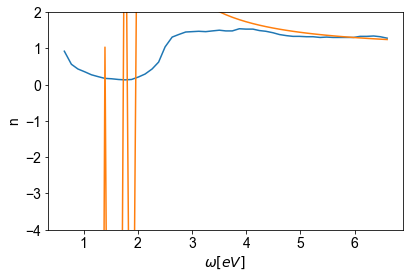

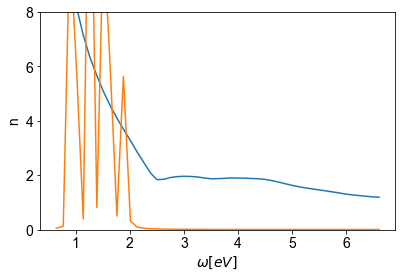

In [7]:
q=[1.99936138e+00, 1.99990749e+00, 1.99998690e+00, 3.17163254e-02,
 1.99999501e+00, 1.99999512e+00, 2.75693429e-03, 1.16177826e-02,
 1.56261195e-02, 3.53010320e-05, 1.79342727e-02, 7.02086861e-03,
 9.02565896e-01, 1.90405353e+00, 1.27844398e+00, 1.02053589e+00,
 1.53276314e+00, 1.66089460e+00]

ev_min=0.001
ev_max=10000
npoints=1000
eV_c = np.logspace(np.log10(ev_min), np.log10(ev_max), npoints)

eps_v = func2(eV,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17])

file2 = np.loadtxt('au.txt')
eV=file2[:,0]
n_JC=file2[:,1] + 1j*file2[:,2]
n=((file2[:,1]+1j*file2[:,2])**.5).real
k=((file2[:,1]+1j*file2[:,2])**.5).imag


er_fit=eps_v.real
ei_fit=eps_v.imag
er_exp=((n + 1j*k)**2).real
er_exp=((n + 1j*k)**2).imag


plt.rc('font', family='Arial', size='14')
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(121)
ax.plot(eV, ((n + 1j*k)**2).real, label="JC")
ax.plot(eV, er_fit, label="Fit")
#plt.xlabel(r'wavelength [$\mu m$] ')
plt.xlabel(r'$\omega [eV]$ ')
plt.ylabel('n')
plt.ylim(-4, 2)

plt.rc('font', family='Arial', size='14')
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(121)
ax.plot(eV, ((n + 1j*k)**2).imag, label="JC")
ax.plot(eV, ei_fit, label="Fit")
#plt.xlabel(r'wavelength [$\mu m$] ')
plt.xlabel(r'$\omega [eV]$ ')
plt.ylabel('n')
plt.ylim(0, 8)
